# **Project 2**
# **MINI TEAM 2**

# Cell 1: Import Libraries

In [ ]:
!pip install streamlit
!pip install mlflow
import pandas as pd
import numpy as np
import streamlit as st
import mlflow.pyfunc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    confusion_matrix
)
from xgboost import XGBClassifier
import shap
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models.signature import infer_signature

# Cell 2: Load Dataset

In [5]:
df = pd.read_csv("/content/diabetic_data (1).csv")

df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Cell 3: Data Cleaning & Preprocessing

In [6]:
# Drop identifiers
df.drop(columns=['encounter_id', 'patient_nbr'], inplace=True, errors='ignore')

# Handle missing values
df.replace('?', np.nan, inplace=True)
df.fillna('Unknown', inplace=True)

# Target variable
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Encode categorical features
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

X = df.drop('readmitted', axis=1)
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Cell 4: Logistic Regression + MLflow

In [7]:
mlflow.set_experiment("Patient_Risk_Logistic")

mlflow.end_run() # Ensure any previous run is ended
with mlflow.start_run():
    log_model = LogisticRegression(max_iter=1000)
    log_model.fit(X_train, y_train)

    preds = log_model.predict(X_test)
    probs = log_model.predict_proba(X_test)[:, 1]

    mlflow.log_params(log_model.get_params())
    mlflow.log_metric("accuracy", accuracy_score(y_test, preds))
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, probs))
    mlflow.log_metric("f1", f1_score(y_test, preds))

    mlflow.sklearn.log_model(
        log_model,
        "logistic_model",
        registered_model_name="PatientRiskModel"
    )

2025/12/18 21:18:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/18 21:18:56 INFO mlflow.store.db.utils: Updating database tables
2025/12/18 21:18:56 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/18 21:18:56 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/18 21:18:56 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2025/12/18 21:18:56 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025/12/18 21:18:56 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025/12/18 21:18:56 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025/12/18 21:18:56 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025/12/18 21:18:56 INFO alembic.runtime.migration: Running 

# Cell 5: XGBoost + MLflow

In [8]:
mlflow.set_experiment("Patient_Risk_XGBoost")

mlflow.end_run() # Ensure any previous run is ended
with mlflow.start_run():
    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        eval_metric="logloss"
    )

    xgb_model.fit(X_train, y_train)

    preds = xgb_model.predict(X_test)
    probs = xgb_model.predict_proba(X_test)[:, 1]

    mlflow.log_params(xgb_model.get_params())
    mlflow.log_metric("accuracy", accuracy_score(y_test, preds))
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, probs))
    mlflow.log_metric("f1", f1_score(y_test, preds))

    # Infer the model signature
    signature = infer_signature(X_train, xgb_model.predict(X_train))

    mlflow.xgboost.log_model(
        xgb_model,
        "xgb_model",
        registered_model_name="PatientRiskModel",
        signature=signature
    )

2025/12/18 21:20:18 INFO mlflow.tracking.fluent: Experiment with name 'Patient_Risk_XGBoost' does not exist. Creating a new experiment.
/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/18 21:20:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Regis

# Cell 6: Neural Network + MLflow

In [9]:
mlflow.set_experiment("Patient_Risk_NeuralNet")

mlflow.end_run() # Ensure any previous run is ended
with mlflow.start_run():
    nn_model = MLPClassifier(
        hidden_layer_sizes=(128, 64),
        max_iter=300
    )

    nn_model.fit(X_train, y_train)

    preds = nn_model.predict(X_test)
    probs = nn_model.predict_proba(X_test)[:, 1]

    mlflow.log_params(nn_model.get_params())
    mlflow.log_metric("accuracy", accuracy_score(y_test, preds))
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, probs))
    mlflow.log_metric("f1", f1_score(y_test, preds))

    mlflow.sklearn.log_model(
        nn_model,
        "nn_model",
        registered_model_name="PatientRiskModel"
    )


2025/12/18 21:20:50 INFO mlflow.tracking.fluent: Experiment with name 'Patient_Risk_NeuralNet' does not exist. Creating a new experiment.
2025/12/18 21:33:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'PatientRiskModel' already exists. Creating a new version of this model...
Created version '3' of model 'PatientRiskModel'.


# Cell 7: Feature Importance

In [12]:
# XGBoost Feature Importance
fi = pd.DataFrame({
    "feature": X.columns,
    "importance": xgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

fi.head(15)


,feature,importance
15,number_inpatient,0.248919
5,discharge_disposition_id,0.076461
46,diabetesMed,0.030424
19,number_diagnoses,0.027090
8,payer_code,0.026429
14,number_emergency,0.024878
20,max_glu_serum,0.024838
16,diag_1,0.024835
23,repaglinide,0.023639
3,weight,0.022993


# Cell 8: SHAP Explainability

100%|===================| 20274/20354 [03:10<00:00]       

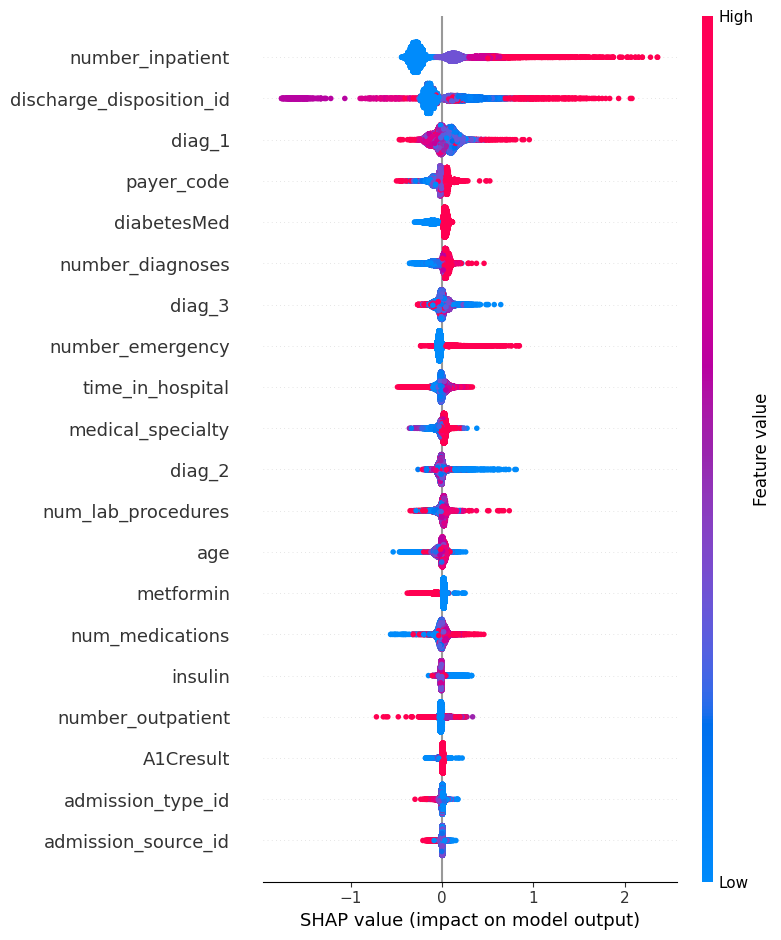

In [13]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


# Cell 9: Confusion Matrix (MLflow Artifact)

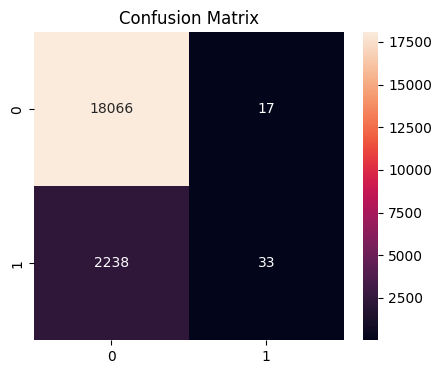

In [14]:
cm = confusion_matrix(y_test, xgb_model.predict(X_test))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

mlflow.log_artifact("confusion_matrix.png")


# Cell 10: Streamlit App (app.py)

In [15]:
st.title("Patient Readmission Risk Assessment")

# Changed 'Production' to 'latest' to load the latest registered model version
model = mlflow.pyfunc.load_model("models:/PatientRiskModel/latest")

inputs = {}
# Check if signature inputs are available, otherwise use X_train.columns as a fallback
if model.metadata and model.metadata.signature and model.metadata.signature.inputs:
    feature_names = model.metadata.signature.inputs.input_names()
else:
    # Fallback: assume X_train columns are the input features
    feature_names = X_train.columns.tolist()

for col in feature_names:
    inputs[col] = st.number_input(col, value=0.0)

input_df = pd.DataFrame([inputs])

if st.button("Predict Risk"):
    prob = model.predict(input_df)[0]
    st.metric("Risk Probability", f"{prob*100:.2f}%")

2025-12-18 21:42:25.614 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-18 21:42:25.617 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-18 21:42:25.618 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-18 21:42:25.677 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-18 21:42:25.678 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-18 21:42:25.680 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-18 21:42:25.681 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-18 21:42:25.684 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar